In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.random_projection import GaussianRandomProjection as GRP

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, adjusted_mutual_info_score as ami

# Convert numpy array to dataframe

In [70]:
np_arr1 = np.array([[1,2,3], [4,5,6]])
df_arr1 = pd.DataFrame(data=np_arr1, columns=['c1','c2','c3'])
print('df_arr1')
print(df_arr1)
np_arr2 = np.array([[3,4,5], [6,7,8]])
df_arr2 = pd.DataFrame(data=np_arr2, columns=['c1','c2','c3'])
print('df_arr2')
print(df_arr2)
rmse = np.sqrt(mean_squared_error(df_arr1, df_arr2))
print('rmse')
print(rmse)


df_arr1
   c1  c2  c3
0   1   2   3
1   4   5   6
df_arr2
   c1  c2  c3
0   3   4   5
1   6   7   8
rmse
2.0


# Load data

In [0]:
random_seed = 1
wine = 'winequality-white.csv'
df = pd.read_csv(wine, sep=';')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
# Standardize
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# Random Projections

In [0]:
def rp(X, Y, random_seed, no_features, ds_name):
  recons_err = []
  fit_time = []
  # max components = no features
  comp = range(1, no_features+5)
  
  for i in comp:
    grp = GRP(n_components = i, random_state=random_seed)
    start = datetime.datetime.now()
    grp.fit(X)
    finish = datetime.datetime.now()
    fit_time.append((finish - start).total_seconds())
    # Calculate recons err
    trans = grp.transform(X)
    pinv = np.linalg.pinv(np.transpose(grp.components_))
    X_recons = np.dot(trans, pinv)
    X_recons = pd.DataFrame(data=X_recons, columns=X.columns)
    rmse = np.sqrt(mean_squared_error(X, X_recons))
    recons_err.append(rmse)
  
  # Plot ICA
  plt.plot(comp,recons_err, marker='o')
  plt.title('RP - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Reconstruction error (RMSE)')
  #plt.legend(loc='best')
  plt.grid()
  plt.show()

  print('Random Projections - Fit times')
  print(*comp)
  print(fit_time)

# Clustering code

In [0]:
from sklearn.metrics import v_measure_score
def kmeans(X, Y, random_seed, ds_name):
  wcss = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_seed)
      start = datetime.datetime.now()
      kmeans.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      labels_pred = kmeans.labels_
      wcss.append(kmeans.inertia_)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,wcss, marker='o')
  plt.title('K means - Elbow Method - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('K means - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()

def em(X, Y, random_seed, ds_name):
  bic = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      gmm = GMM(n_components=i, random_state=random_seed)
      start = datetime.datetime.now()
      gmm.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      #BIC score (lower better)
      bic.append(gmm.bic(X))
      labels_pred = gmm.predict(X)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,bic, marker='o')
  plt.title('EM - BIC to choose optimal components - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('BIC')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('EM - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()


# Neural Networks Code

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def NN(X, Y, plt_title, random_seed=1):
    # Hyperparameter tuning, hidden layer size
    X_train, X_val_test, y_train, y_val_test = \
        train_test_split(X, Y, train_size=0.8, random_state=random_seed)
    hidden_layer_sizes = [2, 4, 6, 8, 10]
    train_score = []
    test_score = []
    for i in hidden_layer_sizes:
        mlp_model = MLPClassifier(hidden_layer_sizes=(i,),random_state=random_seed)
        mlp_model.fit(X=X_train, y=y_train)
        y_train_predict = mlp_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_score.append(train_accuracy)

        y_val_test_predict = mlp_model.predict(X_val_test)
        test_accuracy = accuracy_score(y_val_test, y_val_test_predict)
        test_score.append(test_accuracy)

    df_layers = pd.DataFrame({
        'Hidden layer sizes': hidden_layer_sizes,
        'train score': train_score,
        'validation score': test_score
    })
    print('Hidden layers**************')
    print(df_layers)
    print('hidden_layer_sizes: ', hidden_layer_sizes)
    print('train_score: ', train_score)
    print('test_score: ', test_score)

    # Plot Max depth
    plt.plot(hidden_layer_sizes, train_score, 'o-', color="r",
              label="Training score")
    plt.plot(hidden_layer_sizes, test_score, 'o-', color="g",
              label="Test score")
    plt.legend(loc="best")
    plt.xlabel('Hidden layer sizes')
    plt.ylabel('Accuracy Score')
    plt.title(plt_title)
    plt.show()

# RP - Wine Dataset

RP - Wine Dataset


/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 12).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 13).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 14).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the numb

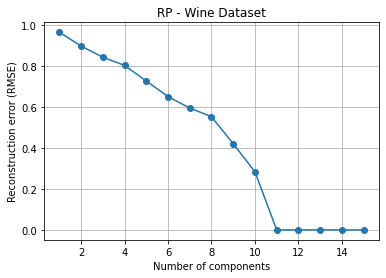

Random Projections - Fit times
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
[0.002993, 0.001362, 0.001362, 0.001351, 0.001401, 0.001411, 0.001338, 0.002951, 0.001442, 0.00136, 0.001346, 0.0019, 0.00165, 0.0018, 0.00171]


In [75]:
print('RP - Wine Dataset')
rp(X=X_std, Y=Y, random_seed=random_seed, no_features=11, ds_name='Wine Dataset')

# RP with K means - Wine Dataset

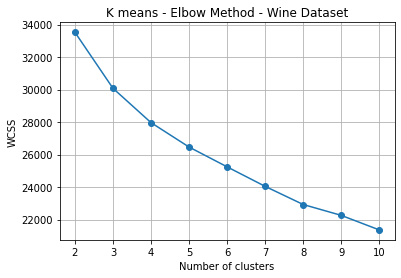

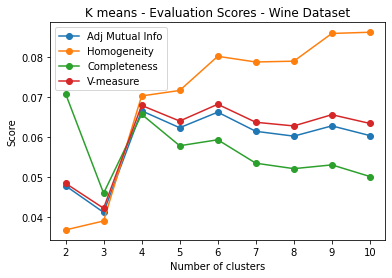

In [76]:
# Choosing n_components = 9 the elbow
grp1 = GRP(n_components = 9, random_state=random_seed)
grp1.fit(X_std)
trans = grp1.transform(X_std)
pinv = np.linalg.pinv(np.transpose(grp1.components_))
X_reduced = np.dot(trans, pinv)
X_reduced = pd.DataFrame(data=X_reduced, columns=X_std.columns)

kmeans(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Wine Dataset')

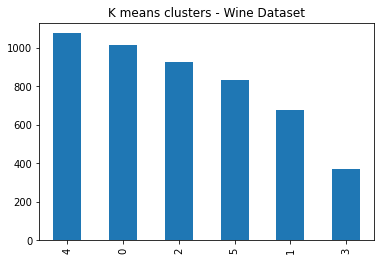

In [77]:
# Choosing k=6 appx from elbow and score peak
kmeans1 = KMeans(n_clusters=6, init='k-means++', random_state=random_seed)
kmeans1.fit(X_reduced)
labels_pred_k = pd.DataFrame(data = kmeans1.labels_, columns=['Cluster labels'])
labels_pred_k['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Wine Dataset')

# RP with Neural Networks - Wine Dataset

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.545431          0.504082
1                   4     0.545176          0.511224
2                   6     0.547728          0.512245
3                   8     0.554620          0.516327
4                  10     0.557427          0.544898
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.5454313425216948, 0.5451761102603369, 0.5477284328739153, 0.5546197039305768, 0.557427258805513]
test_score:  [0.5040816326530613, 0.5112244897959184, 0.5122448979591837, 0.5163265306122449, 0.5448979591836735]


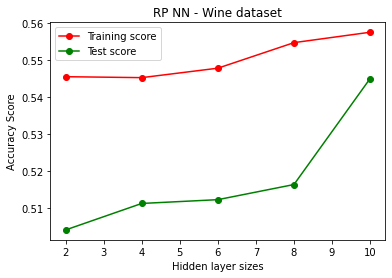

In [78]:
NN(X=X_reduced, Y=Y, plt_title='RP NN - Wine dataset', random_seed=random_seed)

# RP K means - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.449974          0.443878
1                   4     0.449974          0.443878
2                   6     0.449974          0.443878
3                   8     0.449974          0.443878
4                  10     0.449974          0.443878
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4499744767738642, 0.4499744767738642, 0.4499744767738642, 0.4499744767738642, 0.4499744767738642]
test_score:  [0.44387755102040816, 0.44387755102040816, 0.44387755102040816, 0.44387755102040816, 0.44387755102040816]


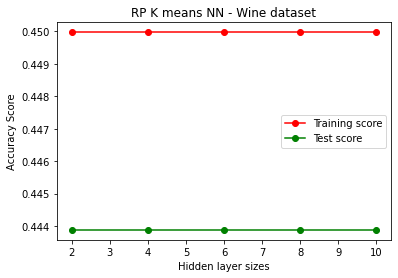

In [79]:
# Using labels from k means as feature X
NN(X=labels_pred_k, Y=Y, plt_title='RP K means NN - Wine dataset', random_seed=random_seed)

# RP with EM - Wine Dataset

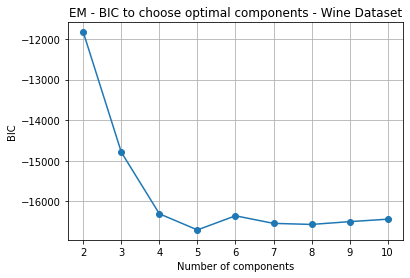

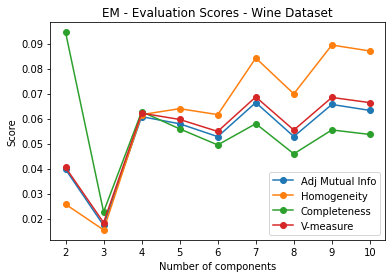

In [80]:
em(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'EM clusters - Wine Dataset')

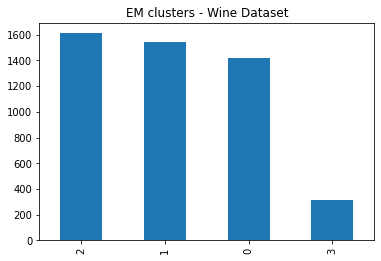

In [81]:
#Choosing components = 4 where BIC lowers significantly
gmm1 = GMM(n_components=4, random_state=random_seed)
gmm1.fit(X_reduced)
labels_pred_em = pd.DataFrame(data = gmm1.predict(X_reduced), columns=['Cluster labels'])
labels_pred_em['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Wine Dataset')

# RP EM - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.455079          0.444898
1                   4     0.449974          0.443878
2                   6     0.487238          0.465306
3                   8     0.482134          0.464286
4                  10     0.482134          0.464286
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4550791220010209, 0.4499744767738642, 0.4872383869321082, 0.4821337417049515, 0.4821337417049515]
test_score:  [0.4448979591836735, 0.44387755102040816, 0.46530612244897956, 0.4642857142857143, 0.4642857142857143]


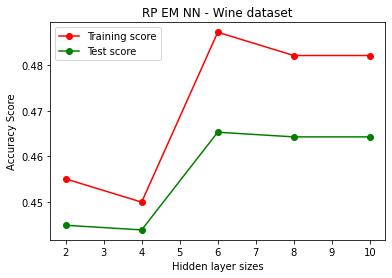

In [82]:
# Using labels from EM as feature X
NN(X=labels_pred_em, Y=Y, plt_title='RP EM NN - Wine dataset', random_seed=random_seed)

# ***Seeds Dataset***

# Load Seeds Data

In [83]:
random_seed = 1
seeds = 'Seed_Data.csv'
df2 = pd.read_csv(seeds)
X2 = df2.iloc[:, :-1]
Y2 = df2.iloc[:, -1]
# Standardize
X_std2 = StandardScaler().fit_transform(X2)
X_std2 = pd.DataFrame(data=X_std2, columns=X2.columns)
X_std2.shape
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

(210, 7)

# RP - Seeds Dataset

/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (7 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of

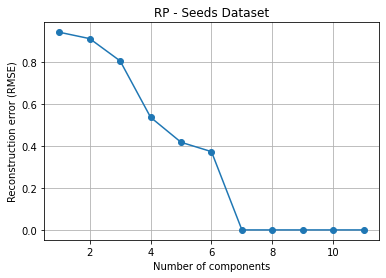

Random Projections - Fit times
1 2 3 4 5 6 7 8 9 10 11
[0.002363, 0.001859, 0.001491, 0.00146, 0.001476, 0.000919, 0.000901, 0.001288, 0.001014, 0.001049, 0.001037]


In [84]:
rp(X=X_std2, Y=Y2, random_seed=random_seed, no_features=7, ds_name='Seeds Dataset')

# RP with K means - Seeds Dataset

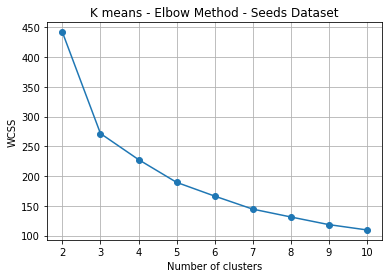

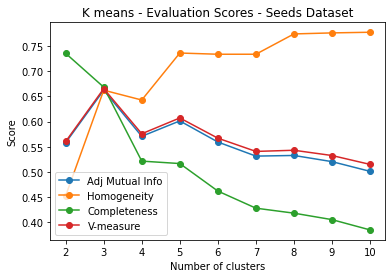

In [85]:
# Choosing n_components = 5 the elbow
grp2 = GRP(n_components = 5, random_state=random_seed)
grp2.fit(X_std2)
trans = grp2.transform(X_std2)
pinv = np.linalg.pinv(np.transpose(grp2.components_))
X_reduced2 = np.dot(trans, pinv)
X_reduced2 = pd.DataFrame(data=X_reduced2, columns=X_std2.columns)

kmeans(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Seeds Dataset')

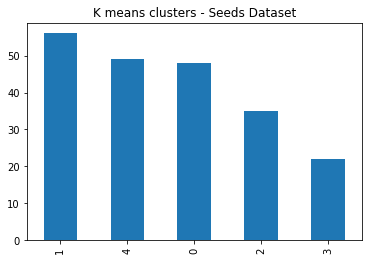

In [86]:
# Choosing k=5 appx from elbow and score peak
kmeans2 = KMeans(n_clusters=5, init='k-means++', random_state=random_seed)
kmeans2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = kmeans2.labels_, columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Seeds Dataset')

# RP with EM - Seeds Dataset

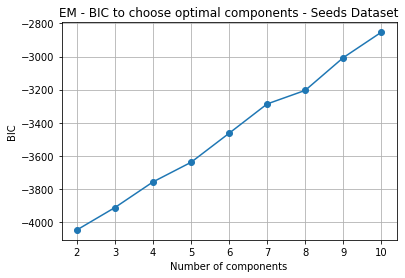

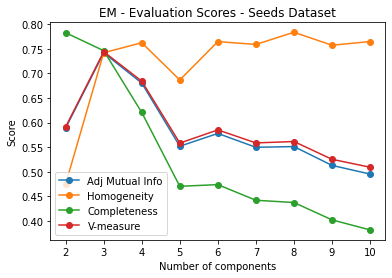

In [87]:
em(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'EM clusters - Wine Dataset')

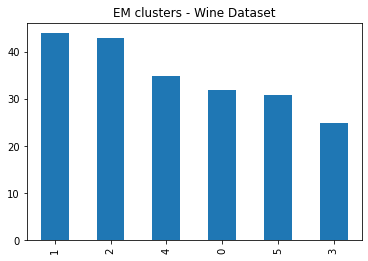

In [88]:
#Choosing components = 6 where BIC lowers significantly
gmm2 = GMM(n_components=6, random_state=random_seed)
gmm2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = gmm2.predict(X_reduced2), columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Wine Dataset')